## 大语言模型 - 10行代码的情感分析解决方案

In [2]:
from openai import OpenAI
import numpy as np
import os

client = OpenAI(api_key=os.environ['OPENAI_API_KEY'])

EMBEDDING_MODEL = "text-embedding-ada-002"

def get_embedding(text, model=EMBEDDING_MODEL):
   text = text.replace("\n", " ")
   return client.embeddings.create(input = [text], model=model).data[0].embedding

def cosine_similarity(vector_a, vector_b):
  dot_product = np.dot(vector_a, vector_b)
  norm_a = np.linalg.norm(vector_a)
  norm_b = np.linalg.norm(vector_b)
  epsilon = 1e-10
  cosine_similarity = dot_product / (norm_a * norm_b + epsilon)
  return cosine_similarity

positive_review = get_embedding("好评")
negative_review = get_embedding("差评")

positive_example = get_embedding("买的银色版真的很好看，一天就到了，晚上就开始拿起来完系统很丝滑流畅，做工扎实，手感细腻，很精致哦苹果一如既往的好品质")
negative_example = get_embedding("随意降价，不予价保，服务态度差")

def get_score(sample_embedding):
  return cosine_similarity(sample_embedding, positive_review) - cosine_similarity(sample_embedding, negative_review)

positive_score = get_score(positive_example)
negative_score = get_score(negative_example)

print("好评例子的评分 : %f" % (positive_score))
print("差评例子的评分 : %f" % (negative_score))

好评例子的评分 : 0.041033
差评例子的评分 : -0.016605


## 语序问题

In [3]:
good_restraurant = get_embedding("这家餐馆太好吃了，一点都不糟糕")
bad_restraurant = get_embedding("这家餐馆太糟糕了，一点都不好吃")

good_score = get_score(good_restraurant)
bad_score = get_score(bad_restraurant)
print("好评餐馆的评分 : %f" % (good_score))
print("差评餐馆的评分 : %f" % (bad_score))

好评餐馆的评分 : 0.051551
差评餐馆的评分 : -0.006473


## 在更大的数据集上的真实案例

In [7]:
import pandas as pd
import numpy as np

from sklearn.metrics import classification_report
datafile_path = os.getcwd() + "/data/fine_food_reviews_with_embeddings_1k.csv"

df = pd.read_csv(datafile_path)
df["embedding"] = df.embedding.apply(eval).apply(np.array)

# convert 5-star rating to binary sentiment
df = df[df.Score != 3]
df["sentiment"] = df.Score.replace({1: "negative", 2: "negative", 4: "positive", 5: "positive"})

## 生成评测结果

              precision    recall  f1-score   support

    negative       0.98      0.73      0.84       136
    positive       0.96      1.00      0.98       789

    accuracy                           0.96       925
   macro avg       0.97      0.86      0.91       925
weighted avg       0.96      0.96      0.96       925



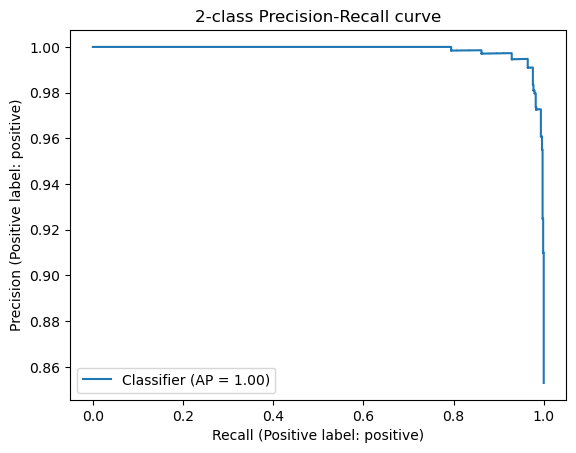

In [8]:
from sklearn.metrics import PrecisionRecallDisplay

def evaluate_embeddings_approach(
    labels = ['negative', 'positive'], 
    model = EMBEDDING_MODEL,
):
    label_embeddings = [get_embedding(label, model=model) for label in labels]

    def label_score(review_embedding, label_embeddings):
        return cosine_similarity(review_embedding, label_embeddings[1]) - cosine_similarity(review_embedding, label_embeddings[0])

    probas = df["embedding"].apply(lambda x: label_score(x, label_embeddings))
    preds = probas.apply(lambda x: 'positive' if x>0 else 'negative')

    report = classification_report(df.sentiment, preds)
    print(report)

    display = PrecisionRecallDisplay.from_predictions(df.sentiment, probas, pos_label='positive')
    _ = display.ax_.set_title("2-class Precision-Recall curve")

evaluate_embeddings_approach(labels=['An Amazon review with a negative sentiment.', 'An Amazon review with a positive sentiment.'])
